In [1]:
import pandas as pd

df = pd.read_csv("playgolf_data.csv")
print("\n Given Play Golf Dataset:\n\n", df)


 Given Play Golf Dataset:

      Outlook Temperature Humidity    Wind PlayGolf
0      Sunny         Hot     High    Weak       No
1      Sunny         Hot     High  Strong       No
2   Overcast         Hot     High    Weak      Yes
3      Rainy        Mild     High    Weak      Yes
4      Rainy        Cool   Normal    Weak      Yes
5      Rainy        Cool   Normal  Strong       No
6   Overcast        Cool   Normal  Strong      Yes
7      Sunny        Mild     High    Weak       No
8      Sunny        Cool   Normal    Weak      Yes
9      Rainy        Mild   Normal    Weak      Yes
10     Sunny        Mild   Normal  Strong      Yes
11  Overcast        Mild     High  Strong      Yes
12  Overcast         Hot   Normal    Weak      Yes
13     Rainy        Mild     High  Strong       No


### Predicting Attributes

In [2]:
t = df.keys()[-1]
print('Target Attribute is   ➡ ', t)

# Get the attribute names from input dataset
attribute_names = list(df.keys())

#Remove the target attribute from the attribute names list
attribute_names.remove(t) 

print('Predicting Attributes ➡ ', attribute_names)

Target Attribute is   ➡  PlayGolf
Predicting Attributes ➡  ['Outlook', 'Temperature', 'Humidity', 'Wind']


### Entropy of the Training Data Set

In [3]:
#Function to calculate the entropy of probaility of observations
# -p*log2*p

import math
def entropy(probs):  
    return sum( [-prob*math.log(prob, 2) for prob in probs])

#Function to calulate the entropy of the given Datasets/List with respect to target attributes
def entropy_of_list(ls,value):  
    from collections import Counter
    
    # Total intances associated with respective attribute
    total_instances = len(ls)  # = 14
    print("---------------------------------------------------------")
    print("\nTotal no of instances/records associated with '{0}' is ➡ {1}".format(value,total_instances))
    # Counter calculates the propotion of class
    cnt = Counter(x for x in ls)
    print('\nTarget attribute class count(Yes/No)=',dict(cnt))
    
    # x means no of YES/NO
    probs = [x / total_instances for x in cnt.values()]  
    print("\nClasses➡", max(cnt), min(cnt))
    print("\nProbabilities of Class 'p'='{0}' ➡ {1}".format(max(cnt),max(probs)))
    print("Probabilities of Class 'n'='{0}'  ➡ {1}".format(min(cnt),min(probs)))
    
    # Call Entropy 
    return entropy(probs) 

### Information Gain of Attributes

In [4]:
def information_gain(df, split_attribute, target_attribute,battr):
    print("\n\n----- Information Gain Calculation of",split_attribute,"----- ") 
    
    # group the data based on attribute values
    df_split = df.groupby(split_attribute) 
    glist=[]
    for gname,group in df_split:
        print('Grouped Attribute Values \n',group)
        print("---------------------------------------------------------")
        glist.append(gname) 
    
    glist.reverse()
    nobs = len(df.index) * 1.0   
    df_agg1=df_split.agg({target_attribute:lambda x:entropy_of_list(x, glist.pop())})
    df_agg2=df_split.agg({target_attribute :lambda x:len(x)/nobs})
    
    df_agg1.columns=['Entropy']
    df_agg2.columns=['Proportion']
    
    # Calculate Information Gain:
    new_entropy = sum( df_agg1['Entropy'] * df_agg2['Proportion'])
    if battr !='S':
        old_entropy = entropy_of_list(df[target_attribute],'S-'+df.iloc[0][df.columns.get_loc(battr)])
    else:
        old_entropy = entropy_of_list(df[target_attribute],battr)
    return old_entropy - new_entropy

### ID3 Algorithm

In [5]:
def id3(df, target_attribute, attribute_names, default_class=None,default_attr='S'):
    
    from collections import Counter
    cnt = Counter(x for x in df[target_attribute])# class of YES /NO
    
    ## First check: Is this split of the dataset homogeneous?
    if len(cnt) == 1:
        return next(iter(cnt))  # next input data set, or raises StopIteration when EOF is hit.
    
    ## Second check: Is this split of the dataset empty? if yes, return a default value
    elif df.empty or (not attribute_names):
        return default_class  # Return None for Empty Data Set
    
    ## Otherwise: This dataset is ready to be devied up!
    else:
        # Get Default Value for next recursive call of this function:
        default_class = max(cnt.keys()) #No of YES and NO Class
        # Compute the Information Gain of the attributes:
        gainz=[]
        for attr in attribute_names:
            ig= information_gain(df, attr, target_attribute,default_attr)
            gainz.append(ig)
            print('\nInformation gain of','“',attr,'”','is ➡', ig)
            print("=========================================================")
        
        index_of_max = gainz.index(max(gainz))               # Index of Best Attribute
        best_attr = attribute_names[index_of_max]            # Choose Best Attribute to split on
        print("\nList of Gain for arrtibutes:",attribute_names,"\nare:", gainz,"respectively.")
        print("\nAttribute with the maximum gain is ➡", best_attr)
        print("\nHence, the Root node will be ➡", best_attr)
        print("=========================================================")

        # Create an empty tree, to be populated in a moment
        tree = {best_attr:{}} # Initiate the tree with best attribute as a node 
        remaining_attribute_names =[i for i in attribute_names if i != best_attr]
        
        # Split dataset-On each split, recursively call this algorithm.Populate the empty tree with subtrees, which
        # are the result of the recursive call
        for attr_val, data_subset in df.groupby(best_attr):
            subtree = id3(data_subset,target_attribute, remaining_attribute_names,default_class,best_attr)
            tree[best_attr][attr_val] = subtree
        return tree

### Tree formation

In [6]:
#Function to calulate the entropy of the given Dataset with respect to target attributes
def entropy_dataset(a_list):  
    from collections import Counter

    # Counter calculates the propotion of class
    cnt = Counter(x for x in a_list)   
    num_instances = len(a_list)*1.0    # = 14
    print("\nNumber of Instances of the Current Sub-Class is {0}".format(num_instances ))
    
    # x means no of YES/NO
    probs = [x / num_instances for x in cnt.values()]  
    print("\nClasses➡", "'p'=",max(cnt), "'n'=",min(cnt))
    print("\nProbabilities of Class 'p'='{0}' ➡ {1}".format(max(cnt),max(probs)))
    print("Probabilities of Class 'n'='{0}'  ➡ {1}".format(min(cnt),min(probs)))
    
    # Call Entropy
    return entropy(probs) 
    
# The initial entropy of the YES/NO attribute for our dataset.
print("Entropy calculation for input dataset:\n")
print(df['PlayGolf'])

total_entropy = entropy_dataset(df['PlayGolf'])
print("\nTotal Entropy(S) of PlayGolf Dataset➡", total_entropy)
print("=========================================================")
####################################################

from pprint import pprint
tree = id3(df,t,attribute_names)
print("\nThe Resultant Decision Tree is: ⤵\n")
pprint(tree)

attribute = next(iter(tree))
print("\nBest Attribute ➡",attribute)
print("Tree Keys      ➡",tree[attribute].keys())

Entropy calculation for input dataset:

0      No
1      No
2     Yes
3     Yes
4     Yes
5      No
6     Yes
7      No
8     Yes
9     Yes
10    Yes
11    Yes
12    Yes
13     No
Name: PlayGolf, dtype: object

Number of Instances of the Current Sub-Class is 14.0

Classes➡ 'p'= Yes 'n'= No

Probabilities of Class 'p'='Yes' ➡ 0.6428571428571429
Probabilities of Class 'n'='No'  ➡ 0.35714285714285715

Total Entropy(S) of PlayGolf Dataset➡ 0.9402859586706309


----- Information Gain Calculation of Outlook ----- 
Grouped Attribute Values 
      Outlook Temperature Humidity    Wind PlayGolf
2   Overcast         Hot     High    Weak      Yes
6   Overcast        Cool   Normal  Strong      Yes
11  Overcast        Mild     High  Strong      Yes
12  Overcast         Hot   Normal    Weak      Yes
---------------------------------------------------------
Grouped Attribute Values 
    Outlook Temperature Humidity    Wind PlayGolf
3    Rainy        Mild     High    Weak      Yes
4    Rainy        Coo


Classes➡ Yes Yes

Probabilities of Class 'p'='Yes' ➡ 1.0
Probabilities of Class 'n'='Yes'  ➡ 1.0
---------------------------------------------------------

Total no of instances/records associated with 'S-Rainy' is ➡ 5

Target attribute class count(Yes/No)= {'Yes': 3, 'No': 2}

Classes➡ Yes No

Probabilities of Class 'p'='Yes' ➡ 0.6
Probabilities of Class 'n'='No'  ➡ 0.4

Information gain of “ Wind ” is ➡ 0.9709505944546686

List of Gain for arrtibutes: ['Temperature', 'Humidity', 'Wind'] 
are: [0.01997309402197489, 0.01997309402197489, 0.9709505944546686] respectively.

Attribute with the maximum gain is ➡ Wind

Hence, the Root node will be ➡ Wind


----- Information Gain Calculation of Temperature ----- 
Grouped Attribute Values 
   Outlook Temperature Humidity  Wind PlayGolf
8   Sunny        Cool   Normal  Weak      Yes
---------------------------------------------------------
Grouped Attribute Values 
   Outlook Temperature Humidity    Wind PlayGolf
0   Sunny         Hot     High 

In [10]:
def classify(instance, tree,default=None):  # Instance of Play Tennis with Predicted    
    attribute = next(iter(tree))            # Outlook/Humidity/Wind       
    if instance[attribute] in tree[attribute].keys(): # Value of the attributs in  set of Tree keys  
        result = tree[attribute][instance[attribute]]
        if isinstance(result, dict):                  # this is a tree, delve deeper
            return classify(instance, result)
        else:
            return result # this is a label
    else:
        return default
    
df_new=pd.read_csv('playgolf_data2.csv')
df_new['Predicted'] = df_new.apply(classify, axis=1, args=(tree,'?')) 
print(df_new)

    Day   Outlook Temperature  Humidity Wind PlayGolf Predicted
0    D1     Sunny        Mild        80   No      Yes      None
1    D2     Sunny         Hot        75  Yes       No      None
2    D3  Overcast         Hot        77   No      Yes       Yes
3    D4     Rainy        Cool        70   No      Yes      None
4    D5  Overcast        Cool        72  Yes      Yes       Yes
5    D6     Sunny        Mild        77   No       No      None
6    D7     Sunny        Cool        70   No      Yes      None
7    D8     Rainy        Mild        69   No      Yes      None
8    D9     Sunny        Mild        65  Yes      Yes      None
9   D10  Overcast        Mild        77  Yes      Yes       Yes
10  D11  Overcast         Hot        74   No      Yes       Yes
11  D12      Rain        Mild        77  Yes       No         ?
12  D13      Rain        Cool        73  Yes       No         ?
13  D14      Rain        Mild        78   No      Yes         ?


---

## Building a Decision Tree using `scikit-learn`

In [11]:
# Importing the necessary module!

import numpy as np
import pandas as pd

In [12]:
# Importing data

df = pd.read_csv("playgolf_data.csv")
df

,Outlook,Temperature,Humidity,Wind,PlayGolf
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rainy,Mild,High,Weak,Yes
4,Rainy,Cool,Normal,Weak,Yes
5,Rainy,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rainy,Mild,Normal,Weak,Yes


In [13]:
df.dtypes

Outlook        object
Temperature    object
Humidity       object
Wind           object
PlayGolf       object
dtype: object

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Outlook      14 non-null     object
 1   Temperature  14 non-null     object
 2   Humidity     14 non-null     object
 3   Wind         14 non-null     object
 4   PlayGolf     14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes


In [15]:
# Converting categorical variables into dummies/indicator variables

df_getdummy=pd.get_dummies(data=df, columns=['Temperature', 'Humidity', 'Outlook', 'Wind'])
df_getdummy

,PlayGolf,Temperature_Cool,Temperature_Hot,Temperature_Mild,Humidity_High,Humidity_Normal,Outlook_Overcast,Outlook_Rainy,Outlook_Sunny,Wind_Strong,Wind_Weak
0,No,0,1,0,1,0,0,0,1,0,1
1,No,0,1,0,1,0,0,0,1,1,0
2,Yes,0,1,0,1,0,1,0,0,0,1
3,Yes,0,0,1,1,0,0,1,0,0,1
4,Yes,1,0,0,0,1,0,1,0,0,1
5,No,1,0,0,0,1,0,1,0,1,0
6,Yes,1,0,0,0,1,1,0,0,1,0
7,No,0,0,1,1,0,0,0,1,0,1
8,Yes,1,0,0,0,1,0,0,1,0,1
9,Yes,0,0,1,0,1,0,1,0,0,1


In [16]:
# Separating the training set and test set

from sklearn.model_selection import train_test_split

X = df_getdummy.drop('PlayGolf',axis=1)
y = df_getdummy['PlayGolf']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [17]:
# importing Decision Tree Classifier via sklean

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='entropy',max_depth=2)
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)

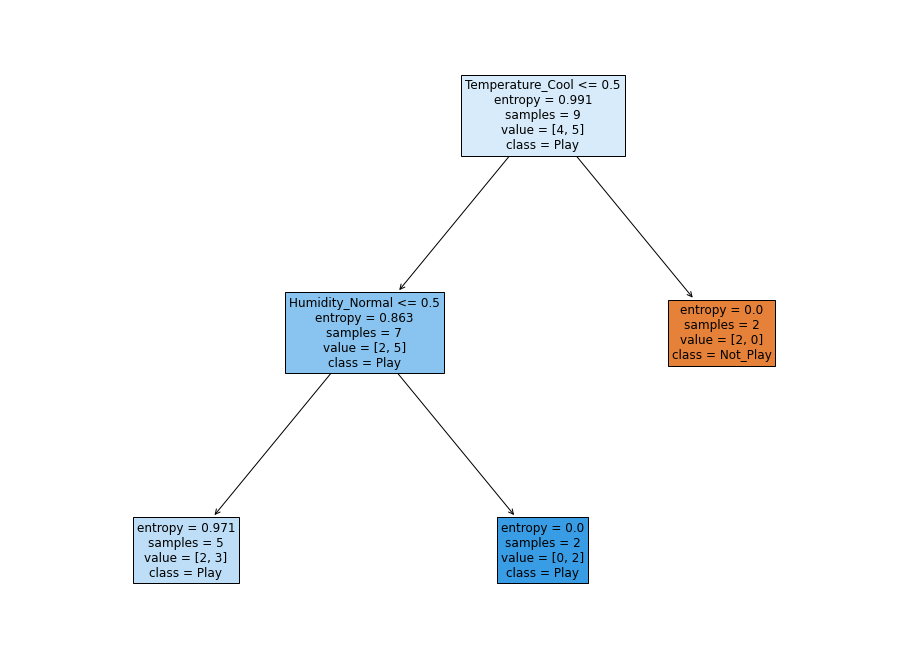

In [18]:
# visualising the decision tree diagram

from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,12))
a = plot_tree(dtree, feature_names=df_getdummy.columns, fontsize=12, filled=True, 
              class_names=['Not_Play', 'Play'])